(2866, 2944)


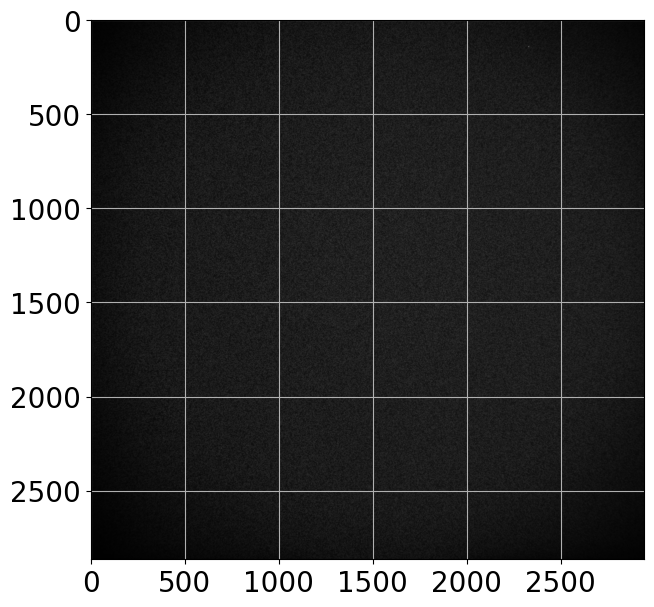

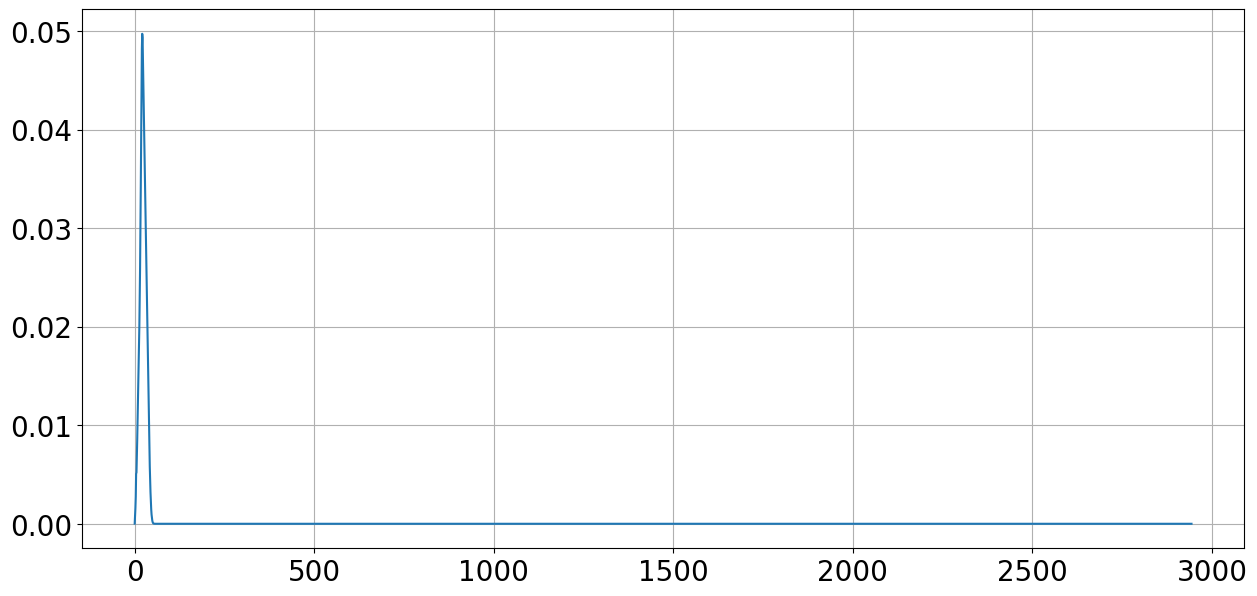

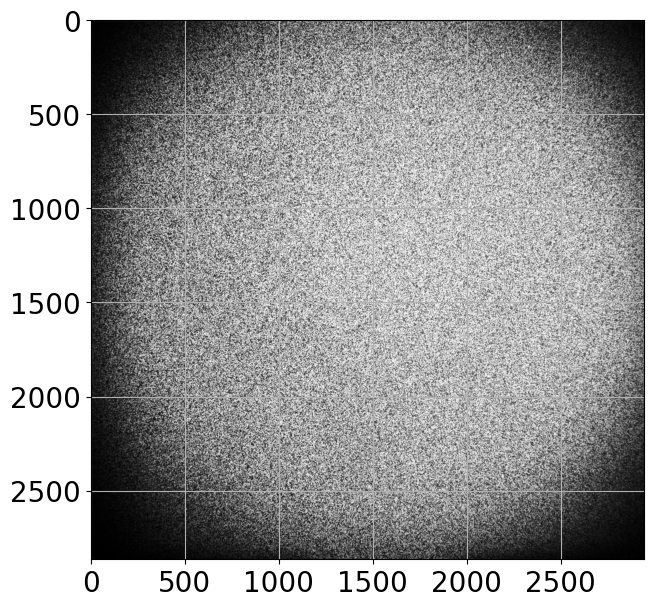

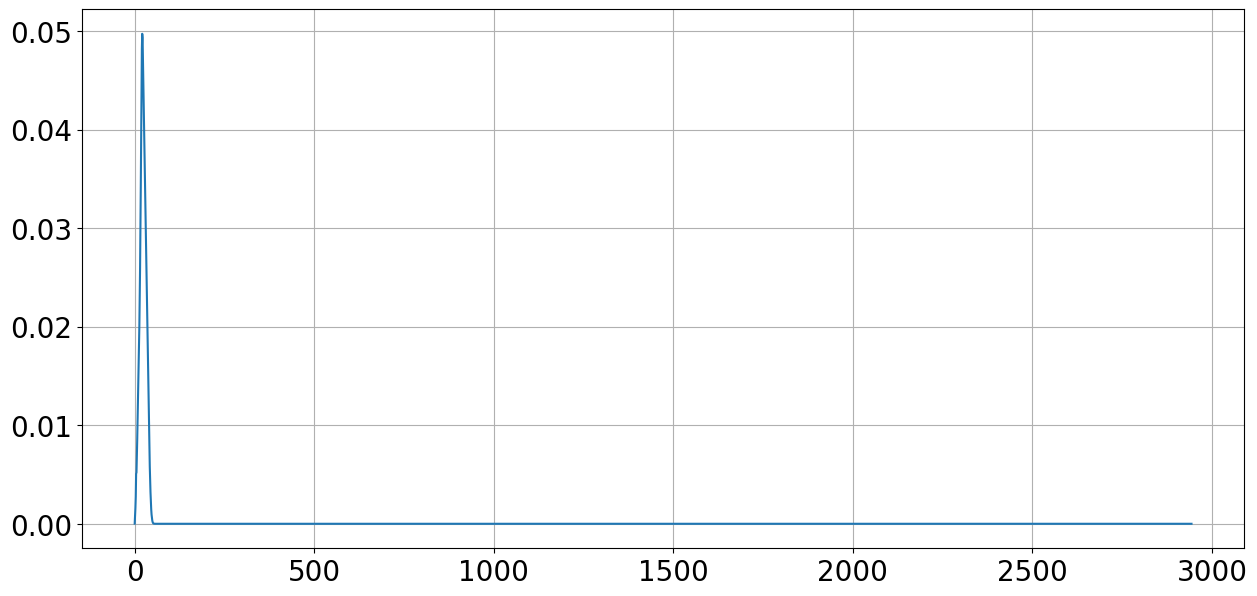

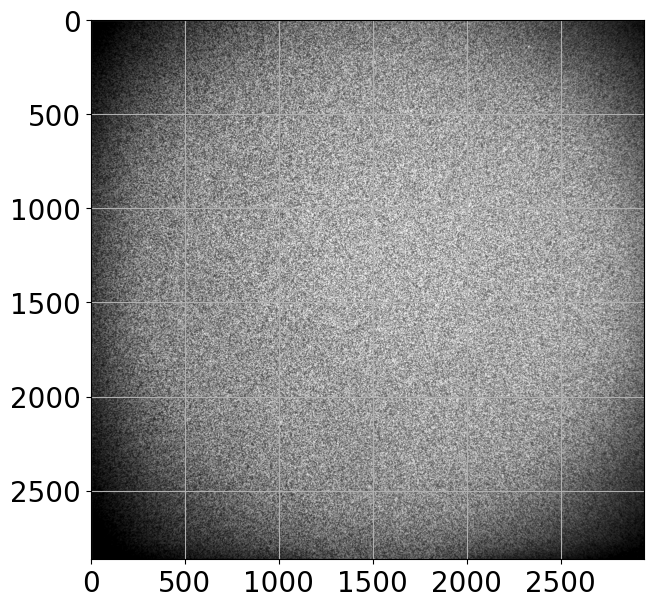

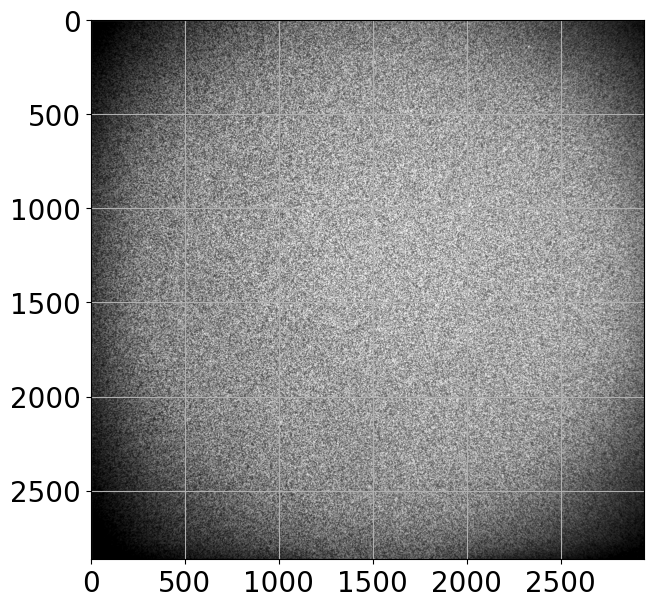

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
#from libtiff import TIFF
from skimage import io
#import pytiff
from tifffile import tifffile
#import OpenImageIO as oiio
#import rasterio
#import tensorflow_io as tfio
import cv2
import scipy
from skimage import color, data, restoration
from scipy.signal import convolve2d
import sporco
import skimage 
from scipy import ndimage
from skimage import measure
import matlab
import matlab.engine 
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl
#import htmlPy
import eel
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)


def gamma_trans(img,gamma):
    # Конкретный метод сначала нормализуется до 1, а затем гамма используется в качестве значения индекса, чтобы найти новое значение пикселя, а затем восстановить
    gamma_table = [np.power(x/255.0,gamma)*255.0 for x in range(256)]
    gamma_table = np.round(np.array(gamma_table)).astype(np.uint8)
    # Реализация сопоставления использует функцию поиска в таблице Opencv
    return cv2.LUT(img0,gamma_table)






import numpy as np
from numpy.fft import fft2, ifft2

def wiener_filter(img, kernel, K = 10):
    dummy = np.copy(img)
    kernel = np.pad(kernel, [(0, dummy.shape[0] - kernel.shape[0]), (0, dummy.shape[1] - kernel.shape[1])], 'constant')
    # Fourier Transform
    dummy = fft2(dummy)
    kernel = fft2(kernel)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return np.uint8(dummy)


def complex_cepstrum(x, n=None):
    r"""Compute the complex cepstrum of a real sequence.
 Parameters
    ----------
 x : ndarray
 Real sequence to compute complex cepstrum of.
 n : {None, int}, optional
 Length of the Fourier transform.
 Returns
    -------
 ceps : ndarray
 The complex cepstrum of the real data sequence `x` computed using the
 Fourier transform.
 ndelay : int
 The amount of samples of circular delay added to `x`.
 The complex cepstrum is given by
 .. math:: c[n] = F^{-1}\\left{\\log_{10}{\\left(F{x[n]}\\right)}\\right}
 where :math:`x_[n]` is the input signal and :math:`F` and :math:`F_{-1}
 are respectively the forward and backward Fourier transform.
 See Also
    --------
 real_cepstrum: Compute the real cepstrum.
 inverse_complex_cepstrum: Compute the inverse complex cepstrum of a real sequence.
 Examples
    --------
 In the following example we use the cepstrum to determine the fundamental
 frequency of a set of harmonics. There is a distinct peak at the quefrency
 corresponding to the fundamental frequency. To be more precise, the peak
 corresponds to the spacing between the harmonics.
 >>> import numpy as np
 >>> import matplotlib.pyplot as plt
 >>> from acoustics.cepstrum import complex_cepstrum
 >>> duration = 5.0
 >>> fs = 8000.0
 >>> samples = int(fs*duration)
 >>> t = np.arange(samples) / fs
 >>> fundamental = 100.0
 >>> harmonics = np.arange(1, 30) * fundamental
 >>> signal = np.sin(2.0*np.pi*harmonics[:,None]*t).sum(axis=0)
 >>> ceps, _ = complex_cepstrum(signal)
    >>> fig = plt.figure()
    >>> ax0 = fig.add_subplot(211)
    >>> ax0.plot(t, signal)
    >>> ax0.set_xlabel('time in seconds')
    >>> ax0.set_xlim(0.0, 0.05)
    >>> ax1 = fig.add_subplot(212)
    >>> ax1.plot(t, ceps)
    >>> ax1.set_xlabel('quefrency in seconds')
    >>> ax1.set_xlim(0.005, 0.015)
    >>> ax1.set_ylim(-5., +10.)
    References
    ----------
    .. [1] Wikipedia, "Cepstrum".
           http://en.wikipedia.org/wiki/Cepstrum
    .. [2] M.P. Norton and D.G. Karczub, D.G.,
           "Fundamentals of Noise and Vibration Analysis for Engineers", 2003.
    .. [3] B. P. Bogert, M. J. R. Healy, and J. W. Tukey:
           "The Quefrency Analysis of Time Series for Echoes: Cepstrum, Pseudo
           Autocovariance, Cross-Cepstrum and Saphe Cracking".
           Proceedings of the Symposium on Time Series Analysis
           Chapter 15, 209-243. New York: Wiley, 1963.
    """

    def _unwrap(phase):
        samples = phase.shape[-1]
        unwrapped = np.unwrap(phase)
        center = (samples + 1) // 2
        if samples == 1:
            center = 0
        ndelay = np.array(np.round(unwrapped[..., center] / np.pi))
        unwrapped -= np.pi * ndelay[..., None] * np.arange(samples) / center
        return unwrapped, ndelay

    spectrum = np.fft.fftn(x)
    unwrapped_phase, ndelay = _unwrap(np.angle(spectrum))
    log_spectrum = np.log(np.abs(spectrum)) + 1j * unwrapped_phase
    ceps = np.fft.ifftn(log_spectrum).real

    return ceps, ndelay


def inverse_complex_cepstrum(ceps, ndelay):
    r"""Compute the inverse complex cepstrum of a real sequence.
    ceps : ndarray
        Real sequence to compute inverse complex cepstrum of.
    ndelay: int
        The amount of samples of circular delay added to `x`.
    Returns
    -------
    x : ndarray
        The inverse complex cepstrum of the real sequence `ceps`.
    The inverse complex cepstrum is given by
    .. math:: x[n] = F^{-1}\left{\exp(F(c[n]))\right}
    where :math:`c_[n]` is the input signal and :math:`F` and :math:`F_{-1}
    are respectively the forward and backward Fourier transform.
    See Also
    --------
    complex_cepstrum: Compute the complex cepstrum of a real sequence.
    real_cepstrum: Compute the real cepstrum of a real sequence.
    Examples
    --------
    Taking the complex cepstrum and then the inverse complex cepstrum results
    in the original sequence.
    >>> import numpy as np
    >>> from acoustics.cepstrum import inverse_complex_cepstrum
    >>> x = np.arange(10)
    >>> ceps, ndelay = complex_cepstrum(x)
    >>> y = inverse_complex_cepstrum(ceps, ndelay)
    >>> print(x)
    >>> print(y)
    References
    ----------
    .. [1] Wikipedia, "Cepstrum".
           http://en.wikipedia.org/wiki/Cepstrum
    """

    def _wrap(phase, ndelay):
        ndelay = np.array(ndelay)
        samples = phase.shape[-1]
        center = (samples + 1) // 2
        wrapped = phase + np.pi * ndelay[..., None] * np.arange(samples) / center
        return wrapped

    log_spectrum = np.fft.fftn(ceps)
    spectrum = np.exp(log_spectrum.real + 1j * _wrap(log_spectrum.imag, ndelay))
    x = np.fft.ifftn(spectrum).real
    return x

def main():
    image = cv2.imread("C:/Users/evgen/Downloads/s_1_1102_c.jpg",0)
    #image=scipy.signal.wiener(image)
    print(image.shape)
    plt.figure(figsize=(15,7))
    plt.imshow(image,cmap='gray')
    plt.grid(True)
    plt.tick_params(labelsize =20,#  Размер подписи
                    color = 'k')   #  Цвет делений
    
    
    
    hist = cv2.calcHist([image], [0], None, [image.shape[1]], [0, image.shape[1]])
    hist=hist/hist.sum()
    plt.figure(figsize=(15,7))
    
    plt.plot(hist.flatten())
    
    plt.grid(True)
    plt.tick_params(labelsize =20,#  Размер подписи
                    color = 'k')   #  Цвет делений
    
    
    image1=cv2.equalizeHist(image,hist)
    plt.figure(figsize=(15,7))
    plt.imshow(image1,cmap='gray')
    plt.grid(True)
    plt.tick_params(labelsize =20,#  Размер подписи
                    color = 'k')   #  Цвет делений
    
    cv2.imwrite("C:/Users/evgen/Downloads/s_1_1102_cequalizeHist.jpg",image1)
    
    hist = cv2.calcHist([image], [0], None, [image1.shape[1]], [0, image1.shape[1]])
    hist=hist/hist.sum()
    plt.figure(figsize=(15,7))
    
    plt.plot(hist.flatten())
    
    plt.grid(True)
    plt.tick_params(labelsize =20,#  Размер подписи
                    color = 'k')   #  Цвет делений
    
    eng = matlab.engine.start_matlab()
    image2=eng.imadjust(image)
    image2=np.asarray(image2)
    #print(image2)
    plt.figure(figsize=(15,7))
    plt.imshow(image2,cmap='gray')
    plt.grid(True)
    plt.tick_params(labelsize =20,#  Размер подписи
                    color = 'k')   #  Цвет делений
    
    cv2.imwrite("C:/Users/evgen/Downloads/s_1_1102_cimadjust.jpg",image2)
    
    image3 = eng.imadjust(image,eng.stretchlim(image),[])
    plt.figure(figsize=(15,7))
    plt.imshow(image3,cmap='gray')
    plt.grid(True)
    plt.tick_params(labelsize =20,#  Размер подписи
                    color = 'k')   #  Цвет делений
    
    cv2.imwrite("C:/Users/evgen/Downloads/s_1_1102_cimadjuststretchlim.jpg",image1)

    
    plt.show()
    
    
        
    
    
if __name__ == "__main__":
    main()